In [ ]:
import os
import pydicom
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, Activation, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

In [ ]:
DATASET_PATH = "C:/Users/jrsl2/Downloads/archive/CT_low_dose_reconstruction_dataset"

def load_dicom_images(folder, size=(128, 128)):
    images = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith((".IMA", ".dcm")):  
                path = os.path.join(root, file)
                try:
                    dicom_data = pydicom.dcmread(path)
                    image = dicom_data.pixel_array
                    image = cv2.resize(image, size)
                    image = image.astype(np.float32) / np.max(image)  
                    images.append(image)
                except Exception as e:
                    print(f"Error {path}: {e}")
    print(f" {folder}: {len(images)}")
    return np.array(images)

original_data_path = os.path.join(DATASET_PATH, "Original Data")

quarter_dose_images = None
full_dose_images = None

for dose_type in ["Quarter Dose", "Full Dose"]:
    dose_path = os.path.join(original_data_path, dose_type)
    images = load_dicom_images(dose_path) 

    if dose_type == "Quarter Dose":
        quarter_dose_images = images
    else:
        full_dose_images = images 

print(f"{quarter_dose_images.shape}")
print(f"{full_dose_images.shape}")


quarter_dose_images = np.expand_dims(quarter_dose_images, axis=-1)
full_dose_images = np.expand_dims(full_dose_images, axis=-1)

print(f"{quarter_dose_images.shape}")
print(f"{full_dose_images.shape}")


Imagens Quarter Dose: (16628, 128, 128)
Imagens Full Dose: (16628, 128, 128)
Quarter Dose após expandir: (16628, 128, 128, 1)
Full Dose após expandir: (16628, 128, 128, 1)


In [31]:
def build_autoencoder(input_shape):
    inputs = Input(shape=input_shape)
    
    # encoder
    x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    
    # decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    outputs = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
    
    return Model(inputs, outputs)

autoencoder = build_autoencoder((128, 128, 1))
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(quarter_dose_images, full_dose_images, epochs=10, batch_size=8, shuffle=True)



Epoch 1/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 117s 56ms/step - loss: 0.0065
Epoch 2/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 119s 57ms/step - loss: 8.5537e-04
Epoch 3/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 117s 56ms/step - loss: 6.9431e-04
Epoch 4/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 123s 59ms/step - loss: 6.1786e-04
Epoch 5/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 1879s 904ms/step - loss: 5.6983e-04
Epoch 6/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 118s 57ms/step - loss: 5.3333e-04
Epoch 7/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 117s 56ms/step - loss: 5.1393e-04
Epoch 8/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 1937s 932ms/step - loss: 4.9378e-04
Epoch 9/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 120s 58ms/step - loss: 4.8142e-04
Epoch 10/10
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 118s 57ms/step - loss: 4.6640e-04


In [33]:
def test_denoising(model, test_image):
    denoised_image = model.predict(np.expand_dims(test_image, axis=0))[0]
    return denoised_image

test_index = 5
test_image = quarter_dose_images[test_index]
clean_image = full_dose_images[test_index]
denosed_image = test_denoising(autoencoder, test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


SSIM: 0.8872


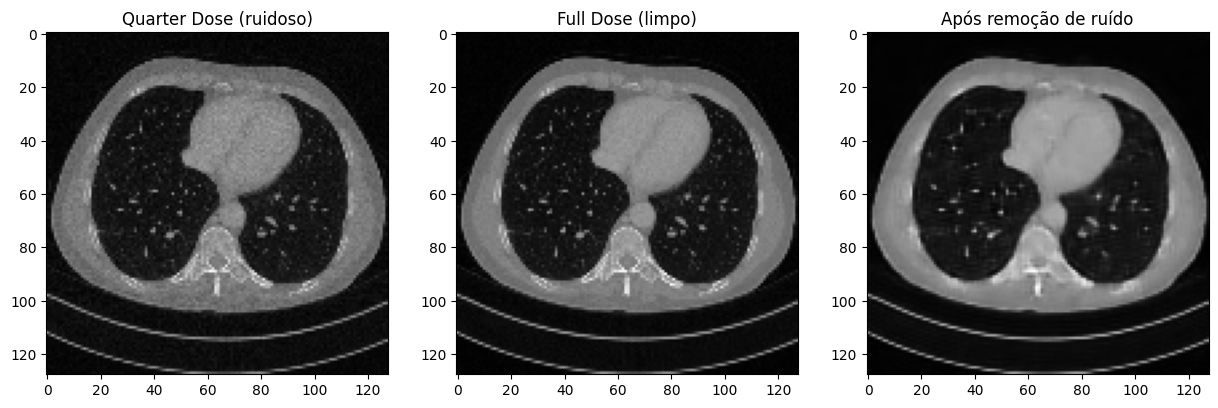

In [ ]:
similarity = ssim(clean_image.squeeze(), denosed_image.squeeze(), data_range=1.0)
print(f"SSIM: {similarity:.4f}")

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(test_image.squeeze(), cmap='gray')
ax[0].set_title("Quarter Dose")
ax[1].imshow(clean_image.squeeze(), cmap='gray')
ax[1].set_title("Full Dose")
ax[2].imshow(denosed_image.squeeze(), cmap='gray')
ax[2].set_title("Após remoção de ruído")
plt.show()

GENERATIVA

In [2]:
DATASET_PATH = "C:/Users/jrsl2/Downloads/archive/CT_low_dose_reconstruction_dataset"

def load_dicom_images(folder, size=(128, 128)):
    images = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith((".IMA", ".dcm")):  
                path = os.path.join(root, file)
                try:
                    dicom_data = pydicom.dcmread(path)
                    image = dicom_data.pixel_array
                    image = cv2.resize(image, size)
                    image = image.astype(np.float32) / np.max(image)  
                    images.append(image)
                except Exception as e:
                    print(f"Error {path}: {e}")
    print(f" {folder}: {len(images)}")
    return np.array(images)

original_data_path = os.path.join(DATASET_PATH, "Original Data")

quarter_dose_images = None
full_dose_images = None

for dose_type in ["Quarter Dose", "Full Dose"]:
    dose_path = os.path.join(original_data_path, dose_type)
    images = load_dicom_images(dose_path) 

    if dose_type == "Quarter Dose":
        quarter_dose_images = images
    else:
        full_dose_images = images 

print(f"{quarter_dose_images.shape}")
print(f"{full_dose_images.shape}")


quarter_dose_images = np.expand_dims(quarter_dose_images, axis=-1)
full_dose_images = np.expand_dims(full_dose_images, axis=-1)

print(f"{quarter_dose_images.shape}")
print(f"{full_dose_images.shape}")

 C:/Users/jrsl2/Downloads/archive/CT_low_dose_reconstruction_dataset\Original Data\Quarter Dose: 16628
 C:/Users/jrsl2/Downloads/archive/CT_low_dose_reconstruction_dataset\Original Data\Full Dose: 16628
(16628, 128, 128)
(16628, 128, 128)
(16628, 128, 128, 1)
(16628, 128, 128, 1)


In [1]:
def build_generator(input_shape=(128, 128, 1)):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=3, padding="same")(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    for _ in range(4):
        x = Conv2D(64, kernel_size=3, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization()(x)

    x = Conv2DTranspose(1, kernel_size=3, padding="same")(x)
    outputs = Activation("tanh")(x)

    return Model(inputs, outputs, name="Generator")

generator = build_generator()


NameError: name 'Input' is not defined

In [33]:
def build_discriminator(input_shape=(128, 128, 1)):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=4, strides=2, padding="same")(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)  
    x = Dense(1, activation="sigmoid")(x)  

    model = Model(inputs, x, name="Discriminator")
    return model

discriminator = build_discriminator()
discriminator.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=["accuracy"])

In [34]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    inputs = Input(shape=(128, 128, 1))
    generated_image = generator(inputs)
    validity = discriminator(generated_image)
    
    return Model(inputs, validity, name="GAN")

gan = build_gan(generator, discriminator)
gan.compile(loss="binary_crossentropy", optimizer="adam")


In [35]:
EPOCHS = 10
BATCH_SIZE = 32

for epoch in range(EPOCHS):
    idx = np.random.randint(0, quarter_dose_images.shape[0], BATCH_SIZE)
    real_images = full_dose_images[idx]
    noisy_images = quarter_dose_images[idx]

    generated_images = generator.predict(noisy_images)

    real_labels = np.ones((BATCH_SIZE, 1))
    fake_labels = np.zeros((BATCH_SIZE, 1))

    discriminator_loss_real = discriminator.train_on_batch(real_images, real_labels)
    discriminator_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)
    discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)

    gan_loss = gan.train_on_batch(noisy_images, real_labels)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, D Loss: {discriminator_loss}, G Loss: {gan_loss}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
Epoch 0, D Loss: [0.6948296 0.3125   ], G Loss: 0.7103950381278992
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Epoch 5, D Loss: [0.6942684  0.43856534], G Loss: 0.6897527575492859
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


In [36]:
def test_gan_denoising(generator, test_image):
    denoised_image = generator.predict(np.expand_dims(test_image, axis=0))[0]    
    return denoised_image

test_index = 5
test_image = quarter_dose_images[test_index]
clean_image = full_dose_images[test_index]

test_image_scaled = (test_image * 2) - 1  

denoised_image = test_gan_denoising(generator, test_image_scaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


SSIM: 0.0738


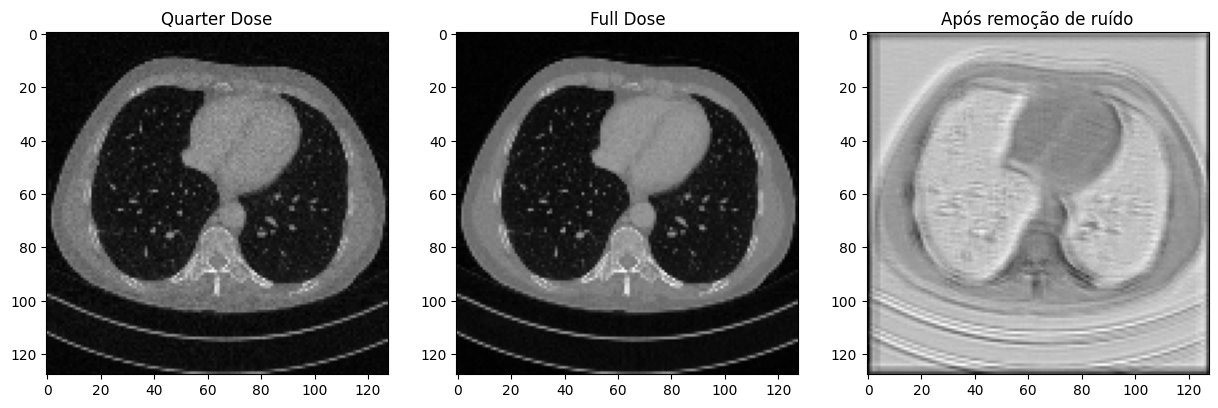

In [37]:
similarity = ssim(clean_image.squeeze(), denoised_image.squeeze(), data_range=1.0)
print(f"SSIM: {similarity:.4f}")

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(test_image.squeeze(), cmap='gray')
ax[0].set_title("Quarter Dose")
ax[1].imshow(clean_image.squeeze(), cmap='gray')
ax[1].set_title("Full Dose")
ax[2].imshow(denoised_image.squeeze(), cmap='gray')
ax[2].set_title("Após remoção de ruído")
plt.show()
